In [1]:
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, middle_size = 100):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.fc1 = nn.Linear(input_size, middle_size)
        self.fc2 = nn.Linear(middle_size, middle_size/2)
        self.fc3 = nn.Linear(middle_size/2, output_size)
        self.cross_ent_loss = nn.CrossEntropyLoss()
    def forward(self, x, target = None):
        x = x.view(-1, self.input_size)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = torch.squeeze(x)
        if target == None:
            return x
        loss = self.cross_ent_loss(x, target)
        return x, loss
    def name(self):
        return 'mlp'
params = ['Px','Py', 'Pz', 'PT', 'E', 'D0', 'DZ', 'X', 'Y',  'Z', 'T', 'count']
N = 15
Nr = N * (N - 1)/2
P = len(params)
Dr = P
De = 5
Dx = 0
Dp = P
fr = MLP(2 * P + Dr, De)
fo = MLP(P + Dx + De, Dp)
classifier = MLP(Dp * N, 5)

In [4]:
import numpy as np
import pandas as pd
import util
df = util.h5_to_df("/bigdata/shared/HepSIM/combo/pythia8_higgs_2_combo.h5")
params = ['Px','Py', 'Pz', 'PT', 'E', 'D0', 'DZ', 'X', 'Y',  'Z', 'T', 'count']
training, target = util.df_to_target(df, output = None, params = params, max_len = N)
training = np.einsum('ijk->ikj', training)
training.shape

reading file
Generate dictionary
['H', 'W+', 'Z', 'b', 'b', 'c', 'c'] 0
['H', 'W+', 'Z', 'b', 'b', 'c'] 0
['H', 'W+', 'Z', 'b', 'b', 's', 's'] 0
['H', 'W+', 'Z', 'b', 'b', 's'] 0
['H', 'W+', 'Z', 'b', 'b', 't'] 0
['H', 'W+', 'Z', 'b', 'b'] 0
['H', 'W+', 'Z', 'b'] 0
['H', 'W+', 'Z', 'c', 'c'] 0
['H', 'W+', 'Z', 'c'] 0
['H', 'W+', 'Z', 's', 's'] 0
['H', 'W+', 'Z', 's'] 0
['H', 'W+', 'Z', 't'] 0
['H', 'W+', 'Z'] 0
['H', 'W+', 'b', 'b', 'c', 'c', 't'] 0
['H', 'W+', 'b', 'b', 'c', 'c'] 0
['H', 'W+', 'b', 'b', 'c', 's'] 0
['H', 'W+', 'b', 'b', 'c', 't'] 0
['H', 'W+', 'b', 'b', 'c'] 0
['H', 'W+', 'b', 'b', 's', 's', 't'] 0
['H', 'W+', 'b', 'b', 's', 's'] 0
['H', 'W+', 'b', 'b', 's', 't'] 0
['H', 'W+', 'b', 'b', 's'] 0
['H', 'W+', 'b', 'b', 't'] 0
['H', 'W+', 'b', 'b'] 0
['H', 'W+', 'b', 't'] 0
['H', 'W+', 'b'] 0
['H', 'W+', 'c', 'c', 's', 's'] 0
['H', 'W+', 'c', 'c', 's'] 0
['H', 'W+', 'c', 'c'] 0
['H', 'W+', 'c', 's', 's'] 0
['H', 'W+', 'c', 's'] 0
['H', 'W+', 'c'] 0
['H', 'W+', 's', 's'] 0


util.py:362: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  l = np.zeros(length)


(1490621, 12, 15)

In [14]:
class GraphNet(nn.Module):
    def __init__(self, n_constituents, params, hidden):
        super(GraphNet, self).__init__()
        self.hidden = hidden
        self.P = len(params)
        self.N = n_constituents
        self.Nr = self.N ** 2
        self.Dr = 0
        self.De = 5
        self.Dx = 0
        self.Do = 6
        self.Rr = Variable(torch.ones(self.N, self.Nr))
        self.Rs = Variable(torch.ones(self.N, self.Nr))
        self.Ra = Variable(torch.ones(self.Dr, self.Nr))
        self.fr1 = nn.Linear(2 * self.P + self.Dr, hidden)
        self.fr2 = nn.Linear(hidden, hidden/2)
        self.fr3 = nn.Linear(hidden/2, self.De)
        self.fo1 = nn.Linear(self.P + self.Dx + self.De, hidden)
        self.fo2 = nn.Linear(hidden, hidden/2)
        self.fo3 = nn.Linear(hidden/2, self.Do)
        self.fc1 = nn.Linear(self.Do * self.N, hidden)
        self.fc2 = nn.Linear(hidden, hidden/2)
        self.fc3 = nn.Linear(hidden/2, 5)
    
    def forward(self, x):
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
        B = nn.functional.relu(self.fr2(B))
        E = self.fr3(B).view(-1, self.Nr, self.De)
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        C = torch.cat([x, Ebar], 1)
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        C = self.fo1(C.view(-1, self.P + self.Dx + self.De))
        C = self.fo2(C)
        O = self.fo3(C).view(-1, self.N, self.Do)
        ### Classification MLP ###
        N = self.fc1(O.view(-1, self.Do * self.N))
        N = self.fc2(N)
        N = self.fc3(N)
        return N

    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.view(-1, x_shape[2]), y).view(-1, x_shape[1], y_shape[1])
    
def get_sample(training, target, choice):
    target_vals = np.argmax(target, axis = 1)
    ind, = np.where(target_vals == choice)
    chosen_ind = np.random.choice(ind, 50000)
    return training[chosen_ind], target[chosen_ind]

samples = [get_sample(training, target, i) for i in range(2)]
trainings = [i[0] for i in samples]
targets = [i[1] for i in samples]
big_training = np.concatenate(trainings)
big_target = np.concatenate(targets)
big_training, big_target = util.shuffle_together(big_training, big_target)

val_split = 0.2
batch_size = 1000
n_epochs = 40

trainingv = Variable(torch.FloatTensor(big_training))
targetv = Variable(torch.from_numpy(np.argmax(big_target, axis = 1)).long())    
trainingv, valv = torch.split(trainingv, int(trainingv.size()[0] * (1 - val_split)))
print trainingv.size(), valv.size()
targetv, val_targetv = torch.split(targetv, int(targetv.size()[0] * (1 - val_split)))
gnn = GraphNet(N, params, 20)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(gnn.parameters())
loss_vals = np.ones(n_epochs)
acc_vals = np.zeros(n_epochs)
for i in range(n_epochs):
    print "Epoch %s" % i
    for j in range(0, trainingv.size()[0], batch_size):
        optimizer.zero_grad()
        out = gnn(trainingv[j:j + batch_size])
        l = loss(out, targetv[j:j + batch_size])
        l.backward()
        optimizer.step()
        loss_string = "Loss: %s" % "{0:.5f}".format(l.data.numpy()[0])
        util.printProgressBar(j + batch_size, trainingv.size()[0], 
                              prefix = "%s [%s/%s] " % (loss_string, 
                                                       j + batch_size, 
                                                       trainingv.size()[0]),
                              length = 70)
    acc_vals[i] = stats(gnn(valv), val_targetv)
    loss_vals[i] = l.data.numpy()[0]
    print

torch.Size([80000, 12, 15]) torch.Size([20000, 12, 15])
Epoch 0
Loss: 0.71931 [80000/80000]  |######################################################################| 100.0% 
  Target 0: 9091/10030 = 90.6380857428%
  Target 1: 3738/9970 = 37.4924774323%
Overall: 12829/20000 = 64.145%

Epoch 1
Loss: 0.73515 [80000/80000]  |######################################################################| 100.0% 
  Target 0: 7338/10030 = 73.1605184447%
  Target 1: 5564/9970 = 55.8074222668%
Overall: 12902/20000 = 64.51%

Epoch 2
Loss: 0.58312 [80000/80000]  |######################################################################| 100.0% 
  Target 0: 9133/10030 = 91.0568295115%
  Target 1: 4338/9970 = 43.5105315948%
Overall: 13471/20000 = 67.355%

Epoch 3
Loss: 0.62737 [80000/80000]  |######################################################################| 100.0% 
  Target 0: 8994/10030 = 89.6709870389%
  Target 1: 4618/9970 = 46.3189568706%
Overall: 13612/20000 = 68.06%

Epoch 4
Loss: 0.59375 [80000/8

Loss: 0.53044 [80000/80000]  |######################################################################| 100.0% 
  Target 0: 9046/10030 = 90.1894317049%
  Target 1: 5127/9970 = 51.4242728185%
Overall: 14173/20000 = 70.865%

Epoch 37
Loss: 0.52929 [80000/80000]  |######################################################################| 100.0% 
  Target 0: 9037/10030 = 90.0997008973%
  Target 1: 5153/9970 = 51.6850551655%
Overall: 14190/20000 = 70.95%

Epoch 38
Loss: 0.52844 [80000/80000]  |######################################################################| 100.0% 
  Target 0: 8958/10030 = 89.3120638086%
  Target 1: 5251/9970 = 52.668004012%
Overall: 14209/20000 = 71.045%

Epoch 39
Loss: 0.52797 [80000/80000]  |######################################################################| 100.0% 
  Target 0: 9002/10030 = 89.7507477567%
  Target 1: 5216/9970 = 52.3169508526%
Overall: 14218/20000 = 71.09%



In [7]:
def accuracy(predict, target):
    _, p_vals = torch.max(predict, 1)
    r = torch.sum(target == p_vals.squeeze(1)).data.numpy()[0]
    t = target.size()[0]
    return r * 1.0 / t

def stats(predict, target):
    _, p_vals = torch.max(predict, 1)
    t = target.data.numpy()
    p_vals = p_vals.squeeze(1).data.numpy()
    vals = np.unique(t)
    for i in vals:
        ind = np.where(t == i)
        pv = p_vals[ind]
        correct = sum(pv == t[ind])
        print "  Target %s: %s/%s = %s%%" % (i, correct, len(pv), correct * 100.0/len(pv))
    print "Overall: %s/%s = %s%%" % (sum(p_vals == t), len(t), sum(p_vals == t) * 100.0/len(t))
    return sum(p_vals == t) * 100.0/len(t)
stats(gnn(trainingv[:100]), targetv[:100])
accuracy(gnn(trainingv[:100]), targetv[:100])

  Target 0: 44/52 = 84.6153846154%
  Target 1: 16/48 = 33.3333333333%
Overall: 60/100 = 60.0%


0.59999999999999998

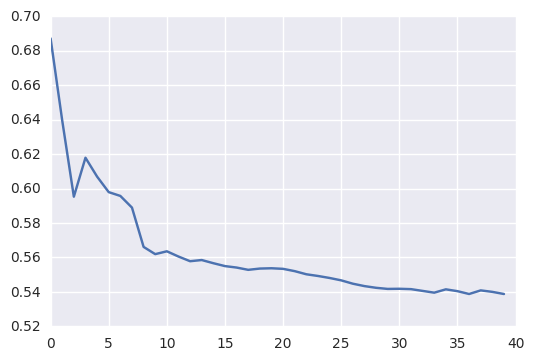

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(loss_vals)